# **FINAL PROJECT- DISCRIMINATING BETWEEN CATS AND OTHER VILLAGERS**

In [68]:
!pip install flashtorch
!pip install barbar                                                             #provides progress bar while training datasets

In [69]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix
from google.colab import drive
import torch

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-18y12vt1
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-18y12vt1
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp37-none-any.whl size=7332 sha256=8d6b592a7cc895dc8848a81c8a1ed3805d1b64a04d7c45b306525b5846f096a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-gqcwlmak/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR


In [70]:
drive.mount('/content/drive')                                                   #mounts google drive (makes it accessible)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/MethodsofComplexSystems/ACNH'
                                                                                #this is creating a data directory or a "path" to find my data sets

In [72]:
os.chdir(data_dir)                                                              #this tells the operating software (os) to change the directory (chdir) to my new directory

In [73]:
dataset_labels =["cats", "other"]

In [74]:
mean = np.array([0.485, 0.456, 0.406])                                          #mean
std = np.array([0.229, 0.224, 0.225])                                           #standard deviation

data_transforms = {
    'train': transforms.Compose([                                               #training set augmentation
        transforms.RandomResizedCrop(224),                                      #randomly crops some of the data
        transforms.RandomHorizontalFlip(),                                      #randomly flips some of the data
        transforms.ToTensor(),                                                  #changes data to tensor format
        transforms.Normalize(mean, std)                                         #normalizes data using previously defined mean and std
    ]),
    'valid': transforms.Compose([                                               #validation data augmentation
        transforms.Resize(256),                                                 #resizes image to 256
        transforms.CenterCrop(224),                                             #crops the image from the center
        transforms.ToTensor(),                                                  #converts to a tensor
        transforms.Normalize(mean, std)                                         #normalizes it
    ])
}

In [75]:
batch_size = 16                                                                 #batchsize
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
                                                                                #this does a lot.
                                                                                #datasets.ImageFolder is loading the data into this thing we're calling Image Folder
                                                                                #os.path.join() is telling the software where to find the data set
                                                                                #then we're saying either train or validate our datasets
                                                                                #data_transforms[] is transforming the data set after loading them in
                                                                                #and we're calling all of this "image_datasets"
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
                                                                                
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [76]:
dataset_sizes

{'train': 198, 'valid': 196}

In [77]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


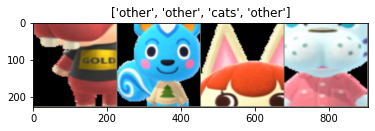

In [79]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [80]:
def train_model(model, num_epochs=25):                                          #we're using an already trained model. we can also change the epochs

    model = model.to(device)                                                    #puts the model on the gpu
    criterion = nn.CrossEntropyLoss()                                           #tells us how well we are doing
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)           #optimizes model parameters
                                                                                #lr is the learning rate
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)          #sets a learning rate schedule for the model

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)                                 #prints what epoch we are on

        ###Train
        model.train()                                                           #training mode
        running_corrects = 0                                                    #sets epoch to 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]                                    #finds the maximum of the outputs (out prediction)
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()                                                    #optimizes the parameters to minimize loss on the next run

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()                                                            #evaluates how well we are doing by using the valid group
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [81]:
model = models.resnet18(pretrained=True)                                        #another pretrained model (resnet)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [82]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train  Acc: 0.87
Valid  Acc: 0.93
#######################
Epoch:  2 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  3 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  4 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  5 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  6 / 30
Train  Acc: 0.95
Valid  Acc: 0.94
#######################
Epoch:  7 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  8 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  9 / 30
Train  Acc: 0.94
Valid  Acc: 0.94
#######################
Epoch:  10 / 30
Train  Acc: 0.95
Valid  Acc: 0.94
#######################
Epoch:  11 / 30
Train  Acc: 0.94
Valid  Acc: 0.94
#######################
Epoch:  12 / 30
Train  Acc: 0.94
Valid  Acc: 0.94
#######################
Epoch:  13 / 30
Train  Acc: 0.95
Valid  Acc: 0.94
#######################
Epoch:  14 / 30
Train  Acc: 0.96
Valid  Acc: 0.94
############

# **FINAL PROJECT- IDENTIFYING ALL VILLAGER SPECIES**

In [83]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/MethodsofComplexSystems/ACNH2'
                                                                                #this is creating a data directory or a "path" to find my data sets

In [84]:
dataset_labels =["Alligators", "Anteaters", "Bears", "Birds", "Bulls", "Cats", "Chickens", "Cows", "Cubs", "Deer", "Dogs", "Ducks", "Eagles", "Elephants", "Frogs", "Goats", "Gorillas", "Hamsters", "Hippos", "Horses", "Kangaroos", "Koalas", "Lions", "Mice", "Monkeys", "Octopus", "Ostrich", "Penguins", "Pigs", "Rabbits", "Rhinos", "Sheep", "Squirrels", "Tigers", "Wolves"]

In [85]:
mean = np.array([0.485, 0.456, 0.406])                                          #mean
std = np.array([0.229, 0.224, 0.225])                                           #standard deviation

data_transforms = {
    'train': transforms.Compose([                                               #training set augmentation
        transforms.RandomResizedCrop(224),                                      #randomly crops some of the data
        transforms.RandomHorizontalFlip(),                                      #randomly flips some of the data
        transforms.ToTensor(),                                                  #changes data to tensor format
        transforms.Normalize(mean, std)                                         #normalizes data using previously defined mean and std
    ]),
    'valid': transforms.Compose([                                               #validation data augmentation
        transforms.Resize(256),                                                 #resizes image to 256
        transforms.CenterCrop(224),                                             #crops the image from the center
        transforms.ToTensor(),                                                  #converts to a tensor
        transforms.Normalize(mean, std)                                         #normalizes it
    ])
}

In [86]:
batch_size = 16                                                                 #batchsize
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
                                                                                #this does a lot.
                                                                                #datasets.ImageFolder is loading the data into this thing we're calling Image Folder
                                                                                #os.path.join() is telling the software where to find the data set
                                                                                #then we're saying either train or validate our datasets
                                                                                #data_transforms[] is transforming the data set after loading them in
                                                                                #and we're calling all of this "image_datasets"
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
                                                                                #
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [87]:
dataset_sizes

{'train': 219, 'valid': 175}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


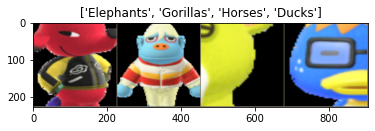

In [88]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [89]:
def train_model(model, num_epochs=25):                                          #we're using an already trained model. we can also change the epochs

    model = model.to(device)                                                    #puts the model on the gpu
    criterion = nn.CrossEntropyLoss()                                           #tells us how well we are doing
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)           #optimizes model parameters
                                                                                #lr is the learning rate
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)          #sets a learning rate schedule for the model

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)                                 #prints what epoch we are on

        ###Train
        model.train()                                                           #training mode
        running_corrects = 0                                                    #sets epoch to 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]                                    #finds the maximum of the outputs (out prediction)
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()                                                    #optimizes the parameters to minimize loss on the next run

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()                                                            #evaluates how well we are doing by using the valid group
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [90]:
model = models.resnet18(pretrained=True)                                        #another pretrained model (resnet)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 35)

In [91]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train  Acc: 0.08
Valid  Acc: 0.06
#######################
Epoch:  2 / 30
Train  Acc: 0.17
Valid  Acc: 0.20
#######################
Epoch:  3 / 30
Train  Acc: 0.34
Valid  Acc: 0.36
#######################
Epoch:  4 / 30
Train  Acc: 0.43
Valid  Acc: 0.33
#######################
Epoch:  5 / 30
Train  Acc: 0.53
Valid  Acc: 0.42
#######################
Epoch:  6 / 30
Train  Acc: 0.61
Valid  Acc: 0.41
#######################
Epoch:  7 / 30
Train  Acc: 0.67
Valid  Acc: 0.47
#######################
Epoch:  8 / 30
Train  Acc: 0.69
Valid  Acc: 0.63
#######################
Epoch:  9 / 30
Train  Acc: 0.77
Valid  Acc: 0.66
#######################
Epoch:  10 / 30
Train  Acc: 0.84
Valid  Acc: 0.67
#######################
Epoch:  11 / 30
Train  Acc: 0.84
Valid  Acc: 0.66
#######################
Epoch:  12 / 30
Train  Acc: 0.84
Valid  Acc: 0.66
#######################
Epoch:  13 / 30
Train  Acc: 0.87
Valid  Acc: 0.64
#######################
Epoch:  14 / 30
Train  Acc: 0.82
Valid  Acc: 0.67
############

##Can we identify Merry cat in the game? (23 cats in the game)



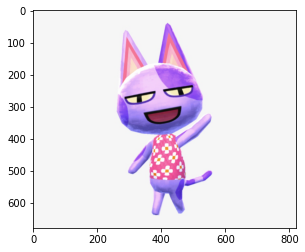

In [92]:
bob = io.imread('https://www.pngkit.com/png/detail/201-2011342_bob-the-cat-animal-crossing.png')
plt.imshow(bob)

In [93]:
cat = apply_transforms(bob).clone().detach().requires_grad_(True).to(device)

In [94]:
outputs = model(cat)
preds = torch.max(outputs, 1)[1]

In [95]:
print('predicted: ' +dataset_labels[preds])

predicted: Cats


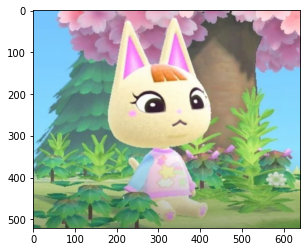

In [96]:
merry = io.imread('https://i.pinimg.com/736x/86/be/5f/86be5f1cb5e46befd334b6ca55e3cfba.jpg')
plt.imshow(merry)

In [97]:
cat = apply_transforms(merry).clone().detach().requires_grad_(True).to(device)

In [98]:
outputs = model(cat)
preds = torch.max(outputs, 1)[1]

In [99]:
print('predicted: ' +dataset_labels[preds])

predicted: Cubs


##Can we identify Carmen the Rabbit? (21 in the game)


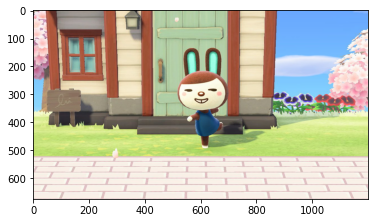

In [100]:
carmen = io.imread('https://pbs.twimg.com/media/EVGRm_JU8AAjSKf.jpg')
plt.imshow(carmen)

In [101]:
rabbit = apply_transforms(carmen).clone().detach().requires_grad_(True).to(device)

In [102]:
outputs = model(rabbit)
preds = torch.max(outputs, 1)[1]

In [103]:
print('predicted: ' +dataset_labels[preds])

predicted: Rabbits


##Can we identify Marina the Octopus? (only 3 octopus in the game)

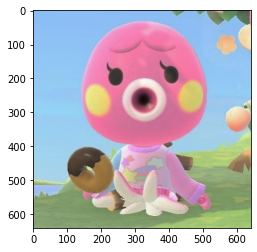

In [104]:
marina = io.imread('https://i.redd.it/1j3saomkwap41.jpg')
plt.imshow(marina)

In [105]:
octopus = apply_transforms(marina).clone().detach().requires_grad_(True).to(device)

In [106]:
outputs = model(octopus)
preds = torch.max(outputs, 1)[1]

In [107]:
print('predicted: ' +dataset_labels[preds])

predicted: Squirrels
